# Prepare expression across cts file
Prepare a file with info on avg expression in each cell type. Uses avg of log-norm expression. Data is  scaled to [0,1] and embryo clusters are removed beforehand.

In [20]:
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams

from marker_genes_collection.access import load as mgc_load

from sklearn.preprocessing import minmax_scale,maxabs_scale

/mnt/znas/icb_zstore01/groups/ml01/code/karin.hrovatin/sfaira/sfaira/versions/metadata/base.py:119: UserWarning: DAG was broken in <class 'sfaira.versions.metadata.base.OntologyMondo'>
  warnings.warn(f"DAG was broken in {type(self)}")
/mnt/znas/icb_zstore01/groups/ml01/code/karin.hrovatin/sfaira/sfaira/versions/metadata/base.py:119: UserWarning: DAG was broken in <class 'sfaira.versions.metadata.base.OntologyUberon'>
  warnings.warn(f"DAG was broken in {type(self)}")


In [2]:
path_full='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'

## Prepare pseudobulk

In [3]:
# Load data with info across cell types
adata_full_rn=sc.read(path_full+'data_rawnorm_integrated_annotated.h5ad')
adata_full_rn.obs['cell_type_integrated_v1']=sc.read(
    path_full+'data_integrated_analysed.h5ad',backed='r').obs['cell_type_integrated_v1']

In [4]:
# Pseudobulk across cts on expressed genes
genes_expressed=adata_full_rn.var_names[
    np.asarray(((adata_full_rn.layers['X_sf_integrated']>0).sum(axis=0)>20)).ravel()]
x_temp=pd.DataFrame(adata_full_rn[:,genes_expressed].layers['X_sf_integrated'].todense(),
                    columns=genes_expressed)
# Use as str so that categories can be latter dropped more easily
x_temp['ct']=adata_full_rn.obs['cell_type_integrated_v1'].astype('str').values
# Do not use embryo cts 
x_temp=x_temp.loc[~x_temp['ct'].str.contains('embryo'),:]
# Avg across cells and scale
x_temp=x_temp.groupby('ct').mean().T

In [ ]:
# Scaled to 0,1
x_temp_scaled=pd.DataFrame(minmax_scale(x_temp,axis=1),
                     index=x_temp.index,columns=x_temp.columns)

In [6]:
# Scaled as ratio of max
x_temp_maxscaled=pd.DataFrame(maxabs_scale(x_temp,axis=1),
                     index=x_temp.index,columns=x_temp.columns)

In [7]:
# Add var names info
x_temp_scaled['gene_symbol']=adata_full_rn[:,x_temp_scaled.index].var['gene_symbol'].values
x_temp_maxscaled['gene_symbol']=adata_full_rn[:,x_temp_maxscaled.index].var['gene_symbol'].values

In [8]:
# Save
x_temp_scaled.to_csv(path_full+'data_integrated_ctAvgScaled_sfintegrated.tsv',sep='\t')
x_temp_maxscaled.to_csv(path_full+'data_integrated_ctAvgMaxScaled_sfintegrated.tsv',sep='\t')

In [9]:
print(path_full+'data_integrated_ctAvgScaled_sfintegrated.tsv')
print(path_full+'data_integrated_ctAvgMaxScaled_sfintegrated.tsv')

/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/data_integrated_ctAvgScaled_sfintegrated.tsv
/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/data_integrated_ctAvgMaxScaled_sfintegrated.tsv


Compare the two scaling options - minmax or maxabs

Text(0.5, 1.0, 'relative beta expression')

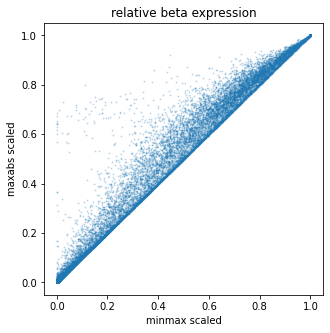

In [19]:
rcParams['figure.figsize']=(5,5)
plt.scatter(x_temp_scaled.beta,x_temp_maxscaled.beta,s=1,alpha=0.2)
plt.xlabel('minmax scaled')
plt.ylabel('maxabs scaled')
plt.title('relative beta expression')

C: Some genes have low minmax scaled expression, but high maxabs scaled expression as they are similarly expressed across ct.

## Use of the relative expression scores for ambience analysis

Check how high beta scores have known non-beta markers.

In [22]:
marker_data = mgc_load()

In [39]:
# Cell types in markers table related with beta cells
beta_like=['pancreatic endocrine cell','progenitor cell of endocrine pancreas','type B pancreatic cell']

In [40]:
# Non-beta mouse pancreatic markers
nonbeta_markers=[g for gs in 
 [adata_full_rn.var.query('gene_symbol ==@g').index.tolist() for g in marker_data.query(
     'cell_type not in @beta_like & organism == "Mus musculus" & tissue == "pancreas"'
                 ).gene_name] for g in gs]

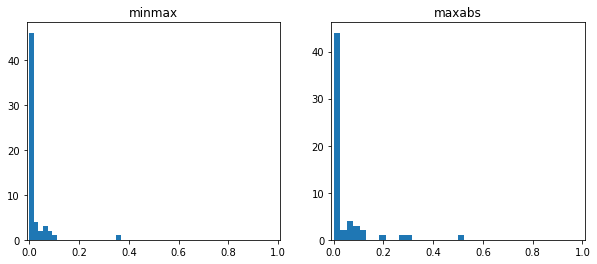

In [44]:
# Beta scores of non-beta markers
fig,ax=plt.subplots(1,2,figsize=(10,4))
for i,(scale,data) in enumerate([('minmax',x_temp_scaled),('maxabs',x_temp_maxscaled)]):
    ax[i].hist(data.loc[nonbeta_markers,'beta'],bins=20)
    ax[i].set_xlim([-0.01,1.01])
    ax[i].set_title(scale)

C: Most non-beta genes have maxabs beta expression <0.15 and almost all <0.3.

It seems that the relative expression scores have potential to be used for identification of potential ambient genes as clear ambient genes have relatively low scores.